# Using Incremental SVD to Predict Wind Speeds
### Amina Shikhalieva and Elena Peot
### (as2642 and ekp38)@cornell.edu

In [1]:
from google.colab import drive
import os
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data loading and cleaning

In [3]:
path = os.path.join(os.getcwd(), "drive", "MyDrive", "3220 Final Project")


humidity = pd.read_csv(os.path.join(path, 'humidity.csv'))
city_attributes = pd.read_csv(os.path.join(path, 'city_attributes.csv'))
pressure = pd.read_csv(os.path.join(path, 'pressure.csv'))
wind_direction = pd.read_csv(os.path.join(path, 'wind_direction.csv'))
wind_speed = pd.read_csv(os.path.join(path, 'wind_speed.csv'))
temperature = pd.read_csv(os.path.join(path, 'temperature.csv'))
weather_description = pd.read_csv(os.path.join(path, 'weather_description.csv'))
datasets = [humidity, pressure, wind_direction, wind_speed, temperature, weather_description]

### Previewing the raw data:

In [4]:
humidity.head(5)

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,San Antonio,Dallas,Houston,Kansas City,Minneapolis,Saint Louis,Chicago,Nashville,Indianapolis,Atlanta,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,25.0,NaN,NaN,NaN
1,2012-10-01 13:00:00,76.0,81.0,88.0,81.0,88.0,82.0,22.0,23.0,50.0,62.0,93.0,87.0,93.0,71.0,67.0,71.0,71.0,100.0,76.0,94.0,76.0,88.0,87.0,83.0,93.0,82.0,71.0,58.0,93.0,68.0,50.0,63.0,22.0,51.0,51.0,50.0
2,2012-10-01 14:00:00,76.0,80.0,87.0,80.0,88.0,81.0,21.0,23.0,49.0,62.0,92.0,86.0,92.0,70.0,66.0,71.0,70.0,99.0,76.0,94.0,75.0,87.0,87.0,82.0,93.0,81.0,70.0,57.0,91.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
3,2012-10-01 15:00:00,76.0,80.0,86.0,80.0,88.0,81.0,21.0,23.0,49.0,62.0,92.0,86.0,90.0,70.0,66.0,71.0,70.0,99.0,76.0,94.0,75.0,87.0,87.0,82.0,93.0,79.0,70.0,57.0,87.0,68.0,51.0,62.0,22.0,51.0,51.0,50.0
4,2012-10-01 16:00:00,77.0,80.0,85.0,79.0,88.0,81.0,21.0,23.0,49.0,62.0,92.0,86.0,89.0,70.0,65.0,71.0,70.0,99.0,76.0,94.0,74.0,87.0,87.0,82.0,93.0,77.0,69.0,57.0,84.0,68.0,52.0,62.0,22.0,51.0,51.0,50.0


In [5]:
city_attributes.head(5)

,City,Country,Latitude,Longitude
0,Vancouver,Canada,49.249660,-123.119339
1,Portland,United States,45.523449,-122.676208
2,San Francisco,United States,37.774929,-122.419418
3,Seattle,United States,47.606209,-122.332069
4,Los Angeles,United States,34.052231,-118.243683


In [6]:
pressure.head(5)

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,San Antonio,Dallas,Houston,Kansas City,Minneapolis,Saint Louis,Chicago,Nashville,Indianapolis,Atlanta,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1011.0,NaN,NaN,NaN
1,2012-10-01 13:00:00,NaN,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,1014.0,1011.0,1009.0,1011.0,1012.0,1010.0,1014.0,1005.0,1011.0,1006.0,1016.0,1009.0,1012.0,1011.0,1015.0,1012.0,1014.0,1012.0,1001.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
2,2012-10-01 14:00:00,NaN,1024.0,1009.0,1027.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,1014.0,1011.0,1008.0,1011.0,1012.0,1010.0,1014.0,1004.0,1011.0,1006.0,1015.0,1009.0,1012.0,1011.0,1015.0,1011.0,1014.0,1012.0,986.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
3,2012-10-01 15:00:00,NaN,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,1014.0,1011.0,1008.0,1011.0,1012.0,1010.0,1014.0,1004.0,1011.0,1006.0,1015.0,1009.0,1012.0,1011.0,1015.0,1011.0,1014.0,1012.0,945.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0
4,2012-10-01 16:00:00,NaN,1024.0,1009.0,1028.0,1013.0,1013.0,1018.0,1013.0,1024.0,1028.0,1014.0,1011.0,1008.0,1011.0,1012.0,1010.0,1014.0,1004.0,1011.0,1006.0,1015.0,1009.0,1012.0,1011.0,1015.0,1010.0,1014.0,1012.0,904.0,1014.0,984.0,1012.0,1010.0,1013.0,1013.0,990.0


In [7]:
wind_direction.head(5)

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,San Antonio,Dallas,Houston,Kansas City,Minneapolis,Saint Louis,Chicago,Nashville,Indianapolis,Atlanta,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,360.0,NaN,NaN,NaN
1,2012-10-01 13:00:00,0.0,0.0,150.0,0.0,0.0,0.0,0.0,10.0,360.0,20.0,0.0,340.0,270.0,0.0,330.0,40.0,0.0,70.0,40.0,110.0,0.0,180.0,70.0,200.0,0.0,240.0,270.0,260.0,230.0,60.0,135.0,101.0,30.0,336.0,336.0,329.0
2,2012-10-01 14:00:00,6.0,4.0,147.0,2.0,0.0,0.0,8.0,9.0,360.0,22.0,5.0,339.0,268.0,6.0,329.0,39.0,0.0,70.0,40.0,110.0,0.0,180.0,70.0,200.0,0.0,236.0,270.0,260.0,230.0,60.0,157.0,315.0,30.0,336.0,336.0,329.0
3,2012-10-01 15:00:00,20.0,18.0,141.0,10.0,0.0,0.0,23.0,9.0,360.0,31.0,18.0,338.0,265.0,20.0,329.0,38.0,0.0,70.0,40.0,111.0,0.0,180.0,71.0,200.0,0.0,226.0,271.0,260.0,231.0,60.0,157.0,307.0,30.0,336.0,336.0,329.0
4,2012-10-01 16:00:00,34.0,31.0,135.0,17.0,0.0,0.0,37.0,9.0,360.0,39.0,31.0,337.0,263.0,34.0,329.0,37.0,0.0,70.0,40.0,111.0,0.0,180.0,71.0,200.0,0.0,216.0,272.0,260.0,233.0,60.0,157.0,294.0,30.0,336.0,336.0,329.0


In [8]:
wind_speed.head(5)

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,San Antonio,Dallas,Houston,Kansas City,Minneapolis,Saint Louis,Chicago,Nashville,Indianapolis,Atlanta,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN,NaN
1,2012-10-01 13:00:00,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,3.0,1.0,0.0,3.0,4.0,0.0,4.0,4.0,3.0,0.0,3.0,4.0,3.0,0.0,3.0,4.0,7.0,4.0,3.0,1.0,0.0,8.0,2.0,2.0,2.0
2,2012-10-01 14:00:00,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,4.0,4.0,0.0,3.0,1.0,0.0,3.0,4.0,0.0,4.0,4.0,3.0,0.0,3.0,4.0,3.0,0.0,3.0,4.0,7.0,4.0,3.0,3.0,0.0,8.0,2.0,2.0,2.0
3,2012-10-01 15:00:00,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,4.0,3.0,0.0,3.0,1.0,0.0,3.0,4.0,0.0,4.0,4.0,3.0,0.0,3.0,4.0,3.0,0.0,3.0,3.0,7.0,4.0,3.0,3.0,0.0,8.0,2.0,2.0,2.0
4,2012-10-01 16:00:00,0.0,0.0,2.0,0.0,0.0,0.0,0.0,2.0,4.0,3.0,0.0,3.0,1.0,0.0,3.0,3.0,0.0,4.0,4.0,3.0,0.0,3.0,4.0,3.0,0.0,3.0,3.0,7.0,4.0,3.0,3.0,0.0,8.0,2.0,2.0,2.0


In [9]:
temperature.head(5)

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,San Antonio,Dallas,Houston,Kansas City,Minneapolis,Saint Louis,Chicago,Nashville,Indianapolis,Atlanta,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,309.100000,NaN,NaN,NaN
1,2012-10-01 13:00:00,284.630000,282.080000,289.480000,281.800000,291.870000,291.530000,293.410000,296.600000,285.120000,284.610000,289.290000,289.740000,288.270000,289.980000,286.870000,286.180000,284.010000,287.410000,283.850000,294.030000,284.030000,298.170000,288.650000,299.720000,281.000000,286.260000,285.630000,288.220000,285.830000,287.170000,307.590000,305.470000,310.580000,304.4,304.4,303.5
2,2012-10-01 14:00:00,284.629041,282.083252,289.474993,281.797217,291.868186,291.533501,293.403141,296.608509,285.154558,284.607306,289.303649,289.762974,288.297576,289.997635,286.893636,286.185246,284.054691,287.421360,283.889394,294.035341,284.069789,298.205230,288.650172,299.732518,281.024767,286.262541,285.663208,288.247676,285.834650,287.186092,307.590000,304.310000,310.495769,304.4,304.4,303.5
3,2012-10-01 15:00:00,284.626998,282.091866,289.460618,281.789833,291.862844,291.543355,293.392177,296.631487,285.233952,284.599918,289.338497,289.830767,288.334343,290.038151,286.951401,286.199194,284.177412,287.454637,283.941919,294.049702,284.173965,298.299595,288.650582,299.766579,281.088319,286.269518,285.756824,288.326940,285.847790,287.231672,307.391513,304.281841,310.411538,304.4,304.4,303.5
4,2012-10-01 16:00:00,284.624955,282.100481,289.446243,281.782449,291.857503,291.553209,293.381213,296.654466,285.313345,284.592530,289.373345,289.898560,288.371111,290.078666,287.009166,286.213142,284.300133,287.487914,283.994444,294.064063,284.278140,298.393961,288.650991,299.800641,281.151870,286.276496,285.850440,288.406203,285.860929,287.277251,307.145200,304.238015,310.327308,304.4,304.4,303.5


In [10]:
weather_description.head(5)

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,Denver,San Antonio,Dallas,Houston,Kansas City,Minneapolis,Saint Louis,Chicago,Nashville,Indianapolis,Atlanta,Detroit,Jacksonville,Charlotte,Miami,Pittsburgh,Toronto,Philadelphia,New York,Montreal,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,haze,NaN,NaN,NaN
1,2012-10-01 13:00:00,mist,scattered clouds,light rain,sky is clear,mist,sky is clear,sky is clear,sky is clear,sky is clear,light rain,sky is clear,mist,sky is clear,sky is clear,broken clouds,sky is clear,overcast clouds,mist,overcast clouds,light rain,sky is clear,scattered clouds,mist,light intensity drizzle,mist,sky is clear,broken clouds,few clouds,overcast clouds,sky is clear,sky is clear,sky is clear,haze,sky is clear,sky is clear,sky is clear
2,2012-10-01 14:00:00,broken clouds,scattered clouds,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,broken clouds,sky is clear,sky is clear,sky is clear,sky is clear,broken clouds,sky is clear,overcast clouds,overcast clouds,overcast clouds,overcast clouds,sky is clear,scattered clouds,overcast clouds,broken clouds,scattered clouds,sky is clear,broken clouds,few clouds,sky is clear,few clouds,sky is clear,sky is clear,broken clouds,overcast clouds,sky is clear,overcast clouds
3,2012-10-01 15:00:00,broken clouds,scattered clouds,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,broken clouds,sky is clear,sky is clear,sky is clear,sky is clear,broken clouds,sky is clear,overcast clouds,overcast clouds,overcast clouds,overcast clouds,sky is clear,scattered clouds,overcast clouds,broken clouds,scattered clouds,sky is clear,broken clouds,few clouds,sky is clear,few clouds,overcast clouds,sky is clear,broken clouds,overcast clouds,overcast clouds,overcast clouds
4,2012-10-01 16:00:00,broken clouds,scattered clouds,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,sky is clear,broken clouds,sky is clear,sky is clear,sky is clear,sky is clear,broken clouds,sky is clear,overcast clouds,overcast clouds,overcast clouds,overcast clouds,sky is clear,scattered clouds,overcast clouds,broken clouds,scattered clouds,sky is clear,broken clouds,few clouds,sky is clear,few clouds,overcast clouds,sky is clear,broken clouds,overcast clouds,overcast clouds,overcast clouds


In [12]:
# find city with most data available
print(humidity.shape, city_attributes.shape, pressure.shape, wind_direction.shape, wind_speed.shape, temperature.shape, weather_description.shape)
cities = np.array(city_attributes['City'])
number_empty = np.zeros(len(cities))
datasets = [humidity, pressure, wind_direction, wind_speed, temperature]
i = 0
for city in cities:
  n = 0
  for dataset in datasets:
    n += dataset[city].isna().sum()
  number_empty[i] = n
  i += 1
print('/n', cities, '\n', number_empty, '\n')
cities[np.argmin(number_empty)]

(45253, 37) (36, 4) (45253, 37) (45253, 37) (45253, 37) (45253, 37) (45253, 37)
/n ['Vancouver' 'Portland' 'San Francisco' 'Seattle' 'Los Angeles'
 'San Diego' 'Las Vegas' 'Phoenix' 'Albuquerque' 'Denver' 'San Antonio'
 'Dallas' 'Houston' 'Kansas City' 'Minneapolis' 'Saint Louis' 'Chicago'
 'Nashville' 'Indianapolis' 'Atlanta' 'Detroit' 'Jacksonville' 'Charlotte'
 'Miami' 'Pittsburgh' 'Toronto' 'Philadelphia' 'New York' 'Montreal'
 'Boston' 'Beersheba' 'Tel Aviv District' 'Eilat' 'Haifa' 'Nahariyya'
 'Jerusalem'] 
 [8445.  456. 4138.  307.  409.  522.  951. 1908. 1172. 2355.  584.  386.
  138.  636.  544. 1360. 1839.  721.  993.  479.  870.  231.  598. 4276.
  573.  906.  634. 5044. 2695.  461. 4049. 4423. 4143. 4002. 3996. 4085.] 



'Houston'

Thus Houston has the most complete data of the cities provided. We will move forward with Houston as our primary subject of study.

## Incremental SVD and FAST implementation

In [14]:
def construct_matrix(city, start_index, window):
  res = []
  for dataset in datasets:
    res.append(dataset[city][start_index:start_index+window])
  return np.array(res)

def slide_window(mat, current_start):
  _, window = mat.shape
  new = mat[:,1:]
  res = []
  for dataset in datasets:
    res.append(dataset[city][current_start+window+1])
  res = np.array(res).reshape(5,1)
  new = np.concatenate((new, res), axis=1)
  return np.array(new)

In [16]:
def FAST(matrix_old, k, steps):
  biggest_s = []
  _, window = matrix_old.shape
  
  U_old, S_old, _ = np.linalg.svd(matrix_old)
  
  U_old = U_old[:,:k]
  S_old = S_old[:k]
  for step in range(steps):
    biggest_s.append(S_old[0])
    matrix_new = slide_window(matrix_old, step+1)
    A = U_old.T @ matrix_new
    z = matrix_new[:,-1] - U_old @ A[:,-1]
    b = np.linalg.norm(z)
    q = z / b
    e = np.zeros(window)
    e[-1] = b

    E = np.append(A, e.reshape((1, window)), axis=0)
    F = E@(E.T)

    U_f, S_f, _ = np.linalg.svd(F)

    # update    
    U_old = np.append(U_old, q.reshape(5,1), axis=1) @ U_f
    S_old = np.sqrt(S_f)
    U_old = U_old[:,:k]
    S_old = S_old[:k]
    
    matrix_old = matrix_new
  return matrix_new, np.array(biggest_s)





In [17]:
# looking into a sample of the distribution of wind speeds we have for Houston
timeframe = 50
wind_speeds_houston = wind_speed['Houston'][1:timeframe]
np.unique(wind_speeds_houston, return_counts=True)

(array([0., 1., 2., 3., 4., 5., 6., 7., 9.]),
 array([ 1,  9, 15, 10,  5,  4,  3,  1,  1]))

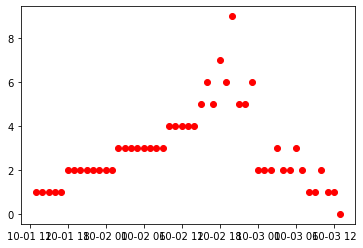

In [18]:
# scratch code
dates = np.array([pd.to_datetime(d) for d in wind_speed['datetime'][1:timeframe]])
plt.scatter(dates, wind_speeds_houston , c = 'red')

In [19]:
# scratch code
h2, sigmas = FAST(h, 3, timeframe)
wind_speeds_houston.shape

(49,)

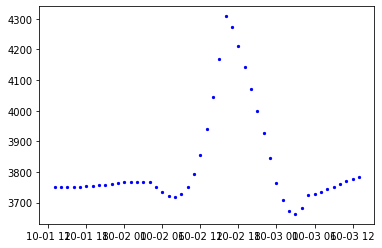

In [20]:
# scratch code
plt.scatter(dates, sigmas[1:] , s=5,c = 'blue')

(49,) (49,) (49,)


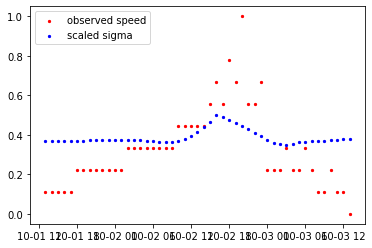

In [21]:
# scratch code
h2, sigmas = FAST(h, 3, timeframe)


fig = plt.figure()
ax1 = fig.add_subplot(111)

scale = wind_speeds_houston.max() + sigmas.max()

wind_speeds_houston *= (1/wind_speeds_houston.max() )
sigmas *= (1/sigmas.max())
sigmas = sigmas[1:] -.5
print(dates.shape, wind_speeds_houston.shape, sigmas.shape)

ax1.scatter(dates, wind_speeds_houston , s=5,c = 'red', label='observed speed')
ax1.scatter(dates, sigmas, s=5,c = 'blue', label='scaled sigma')
plt.legend(loc='upper left');
plt.show()

(49,) (49,) (49,)


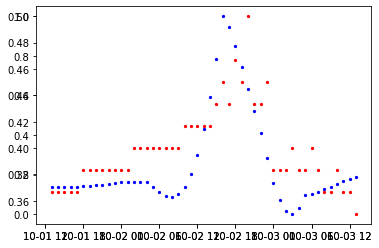

In [22]:
# scratch code
h2, sigmas = FAST(h, 3, timeframe)
 
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2=fig.add_subplot(111, label="2", frame_on=False)

scale = wind_speeds_houston.max() + sigmas.max()

wind_speeds_houston *= (1/wind_speeds_houston.max() )
sigmas *= (1/sigmas.max())
sigmas = sigmas[1:] -.5
print(dates.shape, wind_speeds_houston.shape, sigmas.shape)

ax1.scatter(dates, wind_speeds_houston , s=5,c = 'red', label='observed speed')
ax2.scatter(dates, sigmas, s=5,c = 'blue', label='scaled sigma')
ax2.yaxis.set_label_position('right') 

# plt.legend(loc='upper left');
plt.show()

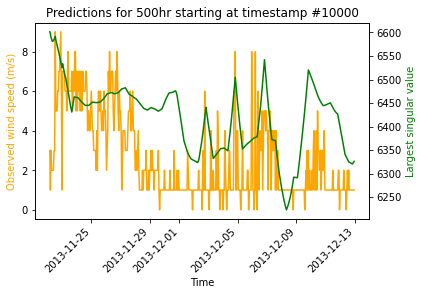

MSE: 8.062032711750742


In [48]:
# preliminary plots 

starttime = 10000
endtime = starttime+500


wind_speeds_houston2 = wind_speed['Houston'][starttime:endtime]
dates2 = np.array([pd.to_datetime(d) for d in wind_speed['datetime'][starttime:endtime]])
h = construct_matrix('Houston', starttime, 36)
h2, sigmas2 = FAST(h, 3, endtime-starttime)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(dates2, wind_speeds_houston2,c = 'orange', label='observed speed')
ax2.plot(dates2, sigmas2, c = 'green', label='sigma')
ax1.set_xlabel('Time')
ax1.set_ylabel('Observed wind speed (m/s)', color='orange')
ax2.set_ylabel('Largest singular value', color='green')
plt.title('Predictions for 500hr starting at timestamp #10000')
fig.autofmt_xdate(rotation=45)

plt.show()

print("MSE:", scale_and_mse(sigmas2, wind_speeds_houston2))

In [26]:
def scale_and_mse(s, w):  
  scaled_winds = (s - np.min(s)) / (np.max(s) -np.min(s)) * (np.max(w) - np.min(w)) + np.min(w)
  mse = ((w - scaled_winds)**2).mean()
  return mse

In [27]:
lowest_mse = 9999999999

for window in range(3, 200):
  wind_speeds_houston2 = wind_speed['Houston'][starttime:endtime]
  dates2 = np.array([pd.to_datetime(d) for d in wind_speed['datetime'][starttime:endtime]])
  h = construct_matrix('Houston', starttime, window)
  h2, sigmas2 = FAST(h, 3, endtime-starttime)
  mse = scale_and_mse(sigmas2, wind_speeds_houston2) 
  if (mse < lowest_mse):
    lowest_mse = mse
    best_window = window
print(lowest_mse, best_window)

3.559640669918734 199


In [28]:
lowest_mse = 9999999999

for window in range(200, 500):
  wind_speeds_houston2 = wind_speed['Houston'][starttime:endtime]
  dates2 = np.array([pd.to_datetime(d) for d in wind_speed['datetime'][starttime:endtime]])
  h = construct_matrix('Houston', starttime, window)
  h2, sigmas2 = FAST(h, 3, endtime-starttime)
  mse = scale_and_mse(sigmas2, wind_speeds_houston2) 
  if (mse < lowest_mse):
    lowest_mse = mse
    best_window = window
print(lowest_mse, best_window)

3.1856521170016103 340


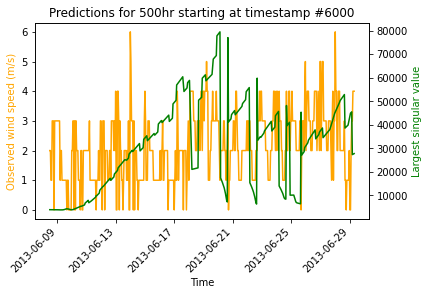

MSE: 2.849914220994091


In [86]:
# best k and window size for a different time range
starttime = 6000
endtime = starttime+500

wind_speeds_houston2 = wind_speed['Houston'][starttime:endtime]
dates2 = np.array([pd.to_datetime(d) for d in wind_speed['datetime'][starttime:endtime]])
_, window = best_window('Houston', 3, starttime, endtime)
_, k = best_k('Houston', window, starttime, endtime)
h = construct_matrix('Houston', starttime, window)
h2, sigmas2 = FAST(h, k, endtime-starttime)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(dates2, wind_speeds_houston2,c = 'orange', label='observed speed')
ax2.plot(dates2, sigmas2, c = 'green', label='sigma')
ax1.set_xlabel('Time')
ax1.set_ylabel('Observed wind speed (m/s)', color='orange')
ax2.set_ylabel('Largest singular value', color='green')
plt.title('Predictions for 500hr starting at timestamp #6000')
fig.autofmt_xdate(rotation=45)

plt.show()

print("MSE:", scale_and_mse(sigmas2, wind_speeds_houston2))

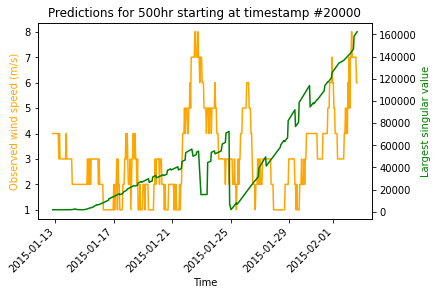

MSE: 3.8498806238070933


In [70]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(dates2, wind_speeds_houston2,c = 'orange', label='observed speed')
ax2.plot(dates2, sigmas2, c = 'green', label='sigma')
ax1.set_xlabel('Time')
ax1.set_ylabel('Observed wind speed (m/s)', color='orange')
ax2.set_ylabel('Largest singular value', color='green')
plt.title('Predictions for 500hr starting at timestamp #20000')
fig.autofmt_xdate(rotation=45)

plt.show()

print("MSE:", scale_and_mse(sigmas2, wind_speeds_houston2))

In [63]:
# best k
def best_k(city, window, starttime, endtime):
  lowest_mse = 9999999999
  for k in range(1,10):
    wind_speeds_houston2 = wind_speed['Houston'][starttime:endtime]
    dates2 = np.array([pd.to_datetime(d) for d in wind_speed['datetime'][starttime:endtime]])
    h = construct_matrix('Houston', starttime, window)
    h2, sigmas2 = FAST(h, k, endtime-starttime)
    mse = scale_and_mse(sigmas2, wind_speeds_houston2) 
    if (mse < lowest_mse):
      lowest_mse = mse
      best_k = k
  return lowest_mse, best_k

def best_window(city, k, starttime, endtime):
  lowest_mse = 9999999999
  for window in range(3, 500):
    wind_speeds_houston2 = wind_speed['Houston'][starttime:endtime]
    dates2 = np.array([pd.to_datetime(d) for d in wind_speed['datetime'][starttime:endtime]])
    h = construct_matrix('Houston', starttime, window)
    
    h2, sigmas2 = FAST(h, 3, endtime-starttime)
    mse = scale_and_mse(sigmas2, wind_speeds_houston2) 
    if (mse < lowest_mse):
      lowest_mse = mse
      best_window = window
  
  return lowest_mse, best_window
  

### Tuning hyperparameters per interval 

In [31]:
def interval_tuner():  
  wind_speed.shape
  interval_wind_variance = []
  interval_best_k = []
  interval_best_window = []
  for i in range(1, 45250, 500):
    starttime = i
    endtime = starttime + 500

    print(starttime, endtime)
    wind_speeds_houston = wind_speed['Houston'][starttime:endtime]
    dates = np.array([pd.to_datetime(d) for d in wind_speed['datetime'][starttime:endtime]])
    interval_wind_variance.append(np.var(wind_speeds_houston))

    try: 
      _, window = best_window('Houston', 3, starttime, endtime)
      _, k = best_k('Houston', window, starttime, endtime)
    
      interval_best_k.append(k)
      interval_best_window.append(window)
    except: # indicates Nan values in the data, so we just skip this interval
      print('skipped')
      continue

  return np.array(interval_wind_variance), np.array(interval_best_k), np.array(interval_best_window)
    

In [32]:
# vars, ks, windows = interval_tuner()

In [33]:
# copied results from prior run of interval_tuner(), which took 2hr and runtime disconnected

windows = np.array([340,  18, 166,   3,  15,   3,  15,   8, 105, 388,  11,  10, 228,
        17,  18,   5, 232, 161, 269, 243,  12,  17,  89,  19,  84,   5,
         6, 245,  17, 242,  13, 340,  15,  15, 234,  15,  16,  16,  11,
        16,  19,  15,  18,  28,   8, 121,   4,  17,  15, 168,   4, 234,
        17,  12,  16, 147,   5,  15,  17,  10,  16, 244,  16,  15, 210,
       127, 121,  16, 119,  15,  15, 341, 442,  12])
vars = np.array([4.49232375, 5.869424  , 4.5096    , 5.452524  , 4.607596  ,
       5.8076    , 4.620064  , 7.619756  , 5.8436    , 5.422636  ,
       5.288096  , 5.358304  , 1.350444  , 1.308096  , 1.603756  ,
       0.890924  , 1.981616  , 2.019584  , 1.979104  , 3.029036  ,
       4.447184  , 0.993776  , 1.2136    , 5.193324  , 5.4424    ,
       5.6835    , 4.953484  , 3.435984  , 3.346256  , 2.434896  ,
       2.506576  , 1.500416  , 1.141964  , 1.219104  , 1.184204  ,
       1.452096  , 1.716     , 2.516064  , 1.495584  , 2.204524  ,
       2.7379    , 2.9376    , 2.478604  , 2.186976  , 1.6075    ,
       2.721296  , 1.5979    , 2.5296    , 2.805584  , 2.335776  ,
       2.3916    , 1.679104  , 1.236076  , 4.0155    , 3.026704  ,
       3.4536    , 4.893296  , 3.5404    , 3.7891    , 4.222256  ,
       5.399436  , 3.644684  , 4.944064  , 3.334384  , 2.005536  ,
       2.292576  , 2.4059    , 1.234816  , 1.947564  , 1.334124  ,
       1.049696  , 1.222284  , 3.487916  , 4.339456  , 4.588784  ,
       4.058624  , 2.870336  , 3.545516  , 4.578444  , 4.0084    ,
       4.597164  , 3.543184  , 3.112076  , 2.249616  , 1.794256  ,
       4.021996  , 6.9216    , 1.928364  , 3.766956  , 2.28562134,
       2.20377454])

In [34]:
windows

array([340,  18, 166,   3,  15,   3,  15,   8, 105, 388,  11,  10, 228,
        17,  18,   5, 232, 161, 269, 243,  12,  17,  89,  19,  84,   5,
         6, 245,  17, 242,  13, 340,  15,  15, 234,  15,  16,  16,  11,
        16,  19,  15,  18,  28,   8, 121,   4,  17,  15, 168,   4, 234,
        17,  12,  16, 147,   5,  15,  17,  10,  16, 244,  16,  15, 210,
       127, 121,  16, 119,  15,  15, 341, 442,  12])

In [35]:
vars

array([4.49232375, 5.869424  , 4.5096    , 5.452524  , 4.607596  ,
       5.8076    , 4.620064  , 7.619756  , 5.8436    , 5.422636  ,
       5.288096  , 5.358304  , 1.350444  , 1.308096  , 1.603756  ,
       0.890924  , 1.981616  , 2.019584  , 1.979104  , 3.029036  ,
       4.447184  , 0.993776  , 1.2136    , 5.193324  , 5.4424    ,
       5.6835    , 4.953484  , 3.435984  , 3.346256  , 2.434896  ,
       2.506576  , 1.500416  , 1.141964  , 1.219104  , 1.184204  ,
       1.452096  , 1.716     , 2.516064  , 1.495584  , 2.204524  ,
       2.7379    , 2.9376    , 2.478604  , 2.186976  , 1.6075    ,
       2.721296  , 1.5979    , 2.5296    , 2.805584  , 2.335776  ,
       2.3916    , 1.679104  , 1.236076  , 4.0155    , 3.026704  ,
       3.4536    , 4.893296  , 3.5404    , 3.7891    , 4.222256  ,
       5.399436  , 3.644684  , 4.944064  , 3.334384  , 2.005536  ,
       2.292576  , 2.4059    , 1.234816  , 1.947564  , 1.334124  ,
       1.049696  , 1.222284  , 3.487916  , 4.339456  , 4.58878

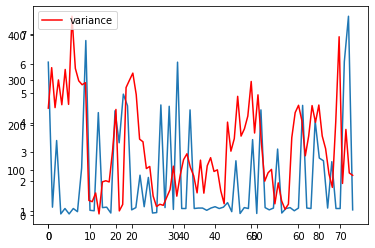

In [36]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = fig.add_subplot(111, label="2", frame_on=False)

ax1.plot(np.arange(windows.size), windows, label='optimal window size')
ax2.plot(np.arange(vars.size), vars, c = 'red', label='variance')
plt.legend(loc='upper left');
plt.show()

3 442


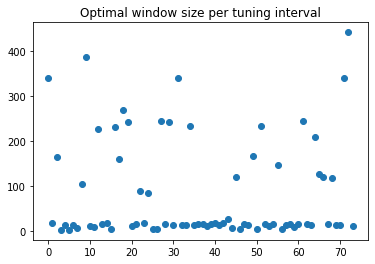

In [37]:
plt.scatter(np.arange(windows.size), windows)
plt.title('Optimal window size per tuning interval')
print(np.min(windows), np.max(windows))

In [38]:
plt.scatter(np.arange(ks.size), ks)
plt.title('Optimal k per tuning interval')
print(np.min(ks), np.max(ks))

NameError: ignored

In [90]:
mean_window_size = np.mean(windows)
mean_window_size

84.87837837837837

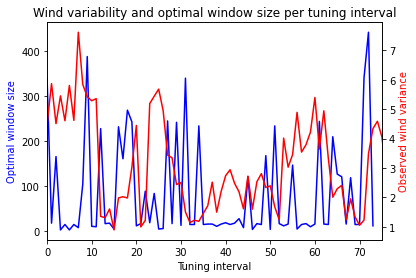

In [91]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(np.arange(windows.size), windows,c='blue', label='optimal window size')
ax2.plot(np.arange(vars.size), vars, c = 'red', label='variance')
ax1.set_xlabel('Tuning interval')
ax1.set_xlim(0,75)
ax1.set_ylabel('Optimal window size', color='b')
ax2.set_ylabel('Observed wind variance', color='r')
plt.title('Wind variability and optimal window size per tuning interval')

plt.show()

In [92]:
lowest_mse = 9999999999
for k in range(1,10):

  wind_speeds_houston2 = wind_speed['Houston'][starttime:endtime]
  dates2 = np.array([pd.to_datetime(d) for d in wind_speed['datetime'][starttime:endtime]])
  h = construct_matrix('Houston', starttime, window)
  h2, sigmas2 = FAST(h, k, endtime-starttime)
  mse = scale_and_mse(sigmas2, wind_speeds_houston2) 
  print(mse,k)
  if (mse < lowest_mse):
    lowest_mse = mse
    best_k = k
print(lowest_mse, best_k)

4.533859912336485 1
4.269666643620596 2
3.968372796859832 3
4.505354022680428 4
5.575494264571741 5
3.667841786786345 6
3.668941771037574 7
3.668836701662299 8
3.666420356254034 9
3.666420356254034 9
